## Artigo 3 - RNA

Continuação do artigo 2 para disciplina de redes neurais artificiais. Esse artigo propõe uma forma de construir e regularizar classificadores baseados em grafos de grabriel de forma eficiente a partir de Extreme Learning Machines

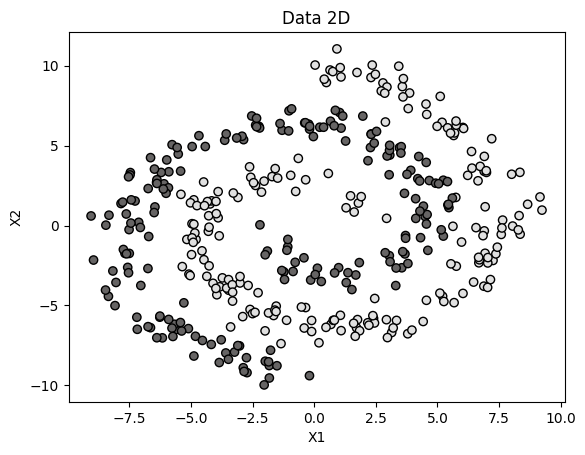

In [60]:
import helper
import numpy as np
import matplotlib.pyplot as plt

X,y = helper.make_spirals(400, noise=0.75)
y = (y==0).astype(int)*-1 + (y==1).astype(int)*1
helper.plot_data(X, y)

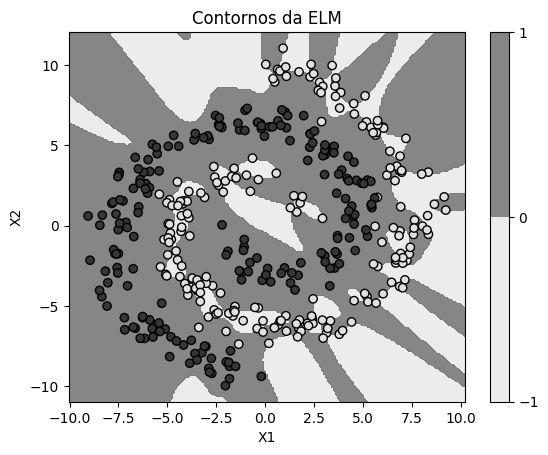

In [61]:
import ELM
from sklearn.model_selection import train_test_split

elm = ELM.ELM(200, random_state=None)
elm.fit(X, y)

elm.plotar_contornos(X, y,grid_size=200)

In [62]:
def select_closest(elm,X,y, k = 0.05):

    #Seleciona os pontos mais proximos da fronteira de decisao
    all_dist = elm.get_geometric_distance(X)
    idx0 = np.where(y == -1)[0]
    idx1 = np.where(y == 1)[0]

    d0 = all_dist[idx0]
    d1 = all_dist[idx1]
    n0 = int(len(idx0)*k)
    n1 = int(len(idx1)*k)
    sel0 = idx0[np.argsort(d0)[:n0]]
    sel1 = idx1[np.argsort(d1)[:n1]]
    selected_idx = np.hstack([sel0, sel1])
    return selected_idx


def select_by_ELM(elm,X, y, k=0.05, rounds=5, verbose=True):
    selected = set()
    for r in range(1, rounds+1):
        elm.fit(X,y)
        new = select_closest(elm,X,y,k=k)
        before = len(selected)
        for i in new: selected.add(int(i))
        if verbose:
            print(f'Rodada {r}: +{len(selected)-before} (total {len(selected)})')
    return np.array(sorted(selected), dtype=int)

def classify_by_nearest_support(graph, new_points):
    """
    Para cada ponto em `new_points`, atribui a classe do vértice de suporte
    mais próximo no grafo de Gabriel `graph`.
    """
    if graph.X is None or graph.y is None:
        raise RuntimeError("Construa o grafo com X e y antes de usar esta função.")

    # índices dos vértices que participam de arestas de suporte (classes opostas conectadas)
    support_indices = {idx for edge in graph.support_edges() for idx in edge}
    if not support_indices:
        raise RuntimeError("Nenhum vértice de suporte disponível no grafo.")

    support_indices = np.array(sorted(support_indices), dtype=int)
    support_points = graph.X.detach().cpu().numpy()[support_indices]
    support_labels = graph.y.detach().cpu().numpy()[support_indices]

    new_points = np.asarray(new_points, dtype=float)
    if new_points.ndim == 1:
        new_points = new_points[None, :]

    # distâncias quadráticas para todos os vértices de suporte
    diff = new_points[:, None, :] - support_points[None, :, :]
    dist2 = np.sum(diff ** 2, axis=2)

    # pega o índice do suporte mais próximo para cada novo ponto
    nearest = np.argmin(dist2, axis=1)
    return support_labels[nearest]

In [63]:
import time

import gg
def rotina_treino(X, y, k_percent=0.10, rounds=10):
    # Dicionário para armazenar o histórico de métricas
    metrics = {
        "reduced_time": [],
        "reduced_acc": [],
        "full_time": [],
        "full_acc": [],
        "final_size": []
    }
    
    for rodada in range(rounds):
        print(f"--- Rodada {rodada+1}/{rounds} ---")
        
        # Split dos dados
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rodada+1)
        X_work, y_work = X_train.copy(), y_train.copy()
        # ==========================================
        # 1. Abordagem Reduzida (ELM Peeling + Gabriel)
        # ==========================================
        t0 = time.time()
        
        # A) Limpeza Inicial: Remove erros do ELM
        elm_clean = ELM.ELM(40, random_state=None)
        for j in range(5):  # Treina várias vezes para estabilidade
            elm_clean.fit(X_work, y_work)
            preds_clean = np.sign(elm_clean.predict(X_work))
            mask_clean = (preds_clean == y_work)
            X_work = X_work[mask_clean]
            y_work = y_work[mask_clean]
        
        selected_indices = select_by_ELM(elm_clean,X_work,y_work,k=k_percent/2,verbose=False,rounds=5)
        mask = np.ones(len(X_work), dtype=bool)
        mask[selected_indices] = False
        X_work = X_work[mask]
        y_work = y_work[mask]
        selected_indices = select_by_ELM(elm_clean,X_work,y_work,k=k_percent,verbose=False,rounds=30)
        
            
        X_final = X_work[selected_indices]
        y_final = y_work[selected_indices]
        
        G1 = gg.GabrielGraph(device='cpu')
        G1.build(X_final, y_final)
        
        t1 = time.time() # Fim do tempo da abordagem reduzida (Seleção + Build)
        
        # Teste Reduzido
        y_pred = classify_by_nearest_support(G1, X_test)
        acc_red = np.mean(y_pred == y_test)
        
        # ==========================================
        # 2. Abordagem Completa (Gabriel Puro)
        # ==========================================
        t2 = time.time()
        G2 = gg.GabrielGraph(device='cpu')
        G2.build(X_train, y_train)
        t3 = time.time() # Fim do tempo da abordagem completa (Apenas Build)
        
        # Teste Completo
        y_pred_full = classify_by_nearest_support(G2, X_test)
        acc_full = np.mean(y_pred_full == y_test)
        
        # ==========================================
        # Armazenamento e Prints
        # ==========================================
        time_red = t1 - t0
        time_full = t3 - t2
        
        metrics["reduced_time"].append(time_red)
        metrics["reduced_acc"].append(acc_red)
        metrics["full_time"].append(time_full)
        metrics["full_acc"].append(acc_full)
        metrics["final_size"].append(len(X_final))

        print(f"   [Reduzido] Acc: {acc_red*100:.2f}% | Tempo: {time_red:.4f}s | Pontos: {len(X_final)}")
        print(f"   [Completo] Acc: {acc_full*100:.2f}% | Tempo: {time_full:.4f}s | Pontos: {len(X_train)}")

    # ==========================================
    # Relatório Final
    # ==========================================
    print("\n" + "="*30)
    print("RESUMO DOS RESULTADOS")
    print("="*30)
    
    mean_acc_red = np.mean(metrics['reduced_acc']) * 100
    std_acc_red = np.std(metrics['reduced_acc']) * 100
    mean_time_red = np.mean(metrics['reduced_time'])
    mean_size_red = np.mean(metrics['final_size'])
    
    mean_acc_full = np.mean(metrics['full_acc']) * 100
    std_acc_full = np.std(metrics['full_acc']) * 100
    mean_time_full = np.mean(metrics['full_time'])
    
    print(f"MÉTODO PROPOSTO (REDUZIDO):")
    print(f"  Acurácia Média: {mean_acc_red:.2f}% (+/- {std_acc_red:.2f})")
    print(f"  Tempo Médio:    {mean_time_red:.4f}s")
    print(f"  Tamanho Médio:  {mean_size_red:.1f} pontos")
    print("-" * 30)
    print(f"GRAFO COMPLETO:")
    print(f"  Acurácia Média: {mean_acc_full:.2f}% (+/- {std_acc_full:.2f})")
    print(f"  Tempo Médio:    {mean_time_full:.4f}s")
    print("="*30)

    return metrics


In [64]:
N = [200, 500, 1000, 2000,3000]
metricas = []
#Preciso exportar os resultados das rotinas para análise posterior
for n in N:
    print(f"\n\n### Experimento com N={n} ###")
    X,y = helper.make_moons(n, noise=0.25)
    y = (y==0).astype(int)*-1 + (y==1).astype(int)*1
    metricas.append(rotina_treino(X, y, k_percent=0.1, rounds=10))

import pandas as pd
import numpy as np

# Lista para o DataFrame final
summary_data = []

# Iterar sobre N e as métricas correspondentes simultaneamente para evitar o erro da variável 'n'
for n_val, metrica in zip(N, metricas):
    
    # Cálculos estatísticos
    acc_red_mean = np.mean(metrica["reduced_acc"]) * 100
    acc_red_std = np.std(metrica["reduced_acc"]) * 100
    
    acc_full_mean = np.mean(metrica["full_acc"]) * 100
    acc_full_std = np.std(metrica["full_acc"]) * 100
    
    time_red_mean = np.mean(metrica["reduced_time"])
    time_full_mean = np.mean(metrica["full_time"])
    
    size_red_mean = np.mean(metrica["final_size"])
    
    # Adicionar ao resumo
    summary_data.append({
        "N": n_val,
        "Acc Reduzido (%)": f"{acc_red_mean:.2f} ± {acc_red_std:.2f}",
        "Acc Completo (%)": f"{acc_full_mean:.2f} ± {acc_full_std:.2f}",
        "Tempo Reduzido (s)": time_red_mean,
        "Tempo Completo (s)": time_full_mean,
        "Tamanho Final": size_red_mean,
        # Mantemos valores numéricos puros para gráficos depois
        "_acc_red_num": acc_red_mean,
        "_acc_full_num": acc_full_mean,
        "_time_red_num": time_red_mean,
        "_time_full_num": time_full_mean
    })

df_results = pd.DataFrame(summary_data)

# Exibir tabela formatada no notebook
display(df_results[["N", "Acc Reduzido (%)", "Acc Completo (%)", "Tempo Reduzido (s)", "Tempo Completo (s)", "Tamanho Final"]])



### Experimento com N=200 ###
--- Rodada 1/10 ---
   [Reduzido] Acc: 90.00% | Tempo: 0.1248s | Pontos: 35
   [Completo] Acc: 92.50% | Tempo: 0.0395s | Pontos: 160
--- Rodada 2/10 ---
   [Reduzido] Acc: 90.00% | Tempo: 0.0339s | Pontos: 57
   [Completo] Acc: 85.00% | Tempo: 0.0566s | Pontos: 160
--- Rodada 3/10 ---
   [Reduzido] Acc: 90.00% | Tempo: 0.0349s | Pontos: 53
   [Completo] Acc: 87.50% | Tempo: 0.0327s | Pontos: 160
--- Rodada 4/10 ---
   [Reduzido] Acc: 92.50% | Tempo: 0.0209s | Pontos: 32
   [Completo] Acc: 100.00% | Tempo: 0.0325s | Pontos: 160
--- Rodada 5/10 ---
   [Reduzido] Acc: 90.00% | Tempo: 0.0223s | Pontos: 53
   [Completo] Acc: 95.00% | Tempo: 0.0378s | Pontos: 160
--- Rodada 6/10 ---
   [Reduzido] Acc: 90.00% | Tempo: 0.0245s | Pontos: 61
   [Completo] Acc: 90.00% | Tempo: 0.0373s | Pontos: 160
--- Rodada 7/10 ---
   [Reduzido] Acc: 92.50% | Tempo: 0.0272s | Pontos: 40
   [Completo] Acc: 90.00% | Tempo: 0.0479s | Pontos: 160
--- Rodada 8/10 ---
   [Reduzido] Ac

,N,Acc Reduzido (%),Acc Completo (%),Tempo Reduzido (s),Tempo Completo (s),Tamanho Final
0,200,92.00 ± 2.92,91.50 ± 4.06,0.039892,0.041322,48.1
1,500,92.80 ± 2.71,88.80 ± 2.68,0.038455,0.255825,95.3
2,1000,94.90 ± 1.51,92.75 ± 1.17,0.105155,0.930983,194.6
3,2000,93.80 ± 1.05,90.62 ± 1.53,0.343748,3.074915,393.0
4,3000,94.63 ± 0.73,90.85 ± 1.39,0.499977,9.058495,508.5


In [65]:
N = [200, 500, 1000, 2000,3000]
metricas = []
#Preciso exportar os resultados das rotinas para análise posterior
for n in N:
    print(f"\n\n### Experimento com N={n} ###")
    X,y = helper.make_circles(n, noise=0.15, factor=.4)
    #helper.plot_data(X, y)
    y = (y==0).astype(int)*-1 + (y==1).astype(int)*1
    metricas.append(rotina_treino(X, y, k_percent=0.1, rounds=10))

import pandas as pd
import numpy as np

# Lista para o DataFrame final
summary_data = []

# Iterar sobre N e as métricas correspondentes simultaneamente para evitar o erro da variável 'n'
for n_val, metrica in zip(N, metricas):
    
    # Cálculos estatísticos
    acc_red_mean = np.mean(metrica["reduced_acc"]) * 100
    acc_red_std = np.std(metrica["reduced_acc"]) * 100
    
    acc_full_mean = np.mean(metrica["full_acc"]) * 100
    acc_full_std = np.std(metrica["full_acc"]) * 100
    
    time_red_mean = np.mean(metrica["reduced_time"])
    time_full_mean = np.mean(metrica["full_time"])
    
    size_red_mean = np.mean(metrica["final_size"])
    
    # Adicionar ao resumo
    summary_data.append({
        "N": n_val,
        "Acc Reduzido (%)": f"{acc_red_mean:.2f} ± {acc_red_std:.2f}",
        "Acc Completo (%)": f"{acc_full_mean:.2f} ± {acc_full_std:.2f}",
        "Tempo Reduzido (s)": time_red_mean,
        "Tempo Completo (s)": time_full_mean,
        "Tamanho Final": size_red_mean,
        # Mantemos valores numéricos puros para gráficos depois
        "_acc_red_num": acc_red_mean,
        "_acc_full_num": acc_full_mean,
        "_time_red_num": time_red_mean,
        "_time_full_num": time_full_mean
    })

df_results2 = pd.DataFrame(summary_data)

# Exibir tabela formatada no notebook
display(df_results2[["N", "Acc Reduzido (%)", "Acc Completo (%)", "Tempo Reduzido (s)", "Tempo Completo (s)", "Tamanho Final"]])
    



### Experimento com N=200 ###
--- Rodada 1/10 ---
   [Reduzido] Acc: 95.00% | Tempo: 0.0347s | Pontos: 41
   [Completo] Acc: 97.50% | Tempo: 0.0421s | Pontos: 160
--- Rodada 2/10 ---
   [Reduzido] Acc: 97.50% | Tempo: 0.0223s | Pontos: 50
   [Completo] Acc: 95.00% | Tempo: 0.0296s | Pontos: 160
--- Rodada 3/10 ---
   [Reduzido] Acc: 95.00% | Tempo: 0.0229s | Pontos: 76
   [Completo] Acc: 90.00% | Tempo: 0.0285s | Pontos: 160
--- Rodada 4/10 ---
   [Reduzido] Acc: 100.00% | Tempo: 0.0194s | Pontos: 46
   [Completo] Acc: 100.00% | Tempo: 0.0380s | Pontos: 160
--- Rodada 5/10 ---
   [Reduzido] Acc: 100.00% | Tempo: 0.0403s | Pontos: 61
   [Completo] Acc: 97.50% | Tempo: 0.0344s | Pontos: 160
--- Rodada 6/10 ---
   [Reduzido] Acc: 92.50% | Tempo: 0.0247s | Pontos: 55
   [Completo] Acc: 97.50% | Tempo: 0.0344s | Pontos: 160
--- Rodada 7/10 ---
   [Reduzido] Acc: 97.50% | Tempo: 0.0221s | Pontos: 58
   [Completo] Acc: 97.50% | Tempo: 0.0407s | Pontos: 160
--- Rodada 8/10 ---
   [Reduzido] 

,N,Acc Reduzido (%),Acc Completo (%),Tempo Reduzido (s),Tempo Completo (s),Tamanho Final
0,200,94.75 ± 4.25,96.25 ± 3.01,0.026824,0.036265,52.5
1,500,96.70 ± 1.90,97.00 ± 1.67,0.055712,0.245872,136.0
2,1000,96.45 ± 1.01,94.80 ± 1.12,0.177179,0.944633,254.8
3,2000,96.82 ± 0.42,95.80 ± 0.93,0.482738,3.020840,510.9
4,3000,96.82 ± 0.69,95.87 ± 0.66,1.270391,10.623990,817.9


In [66]:
N = [200, 500, 1000, 2000,3000]
metricas = []
#Preciso exportar os resultados das rotinas para análise posterior
for n in N:
    print(f"\n\n### Experimento com N={n} ###")
    X,y = helper.make_spirals(n, noise=.8)
    #helper.plot_data(X, y)
    #y = (y==0).astype(int)*-1 + (y==1).astype(int)*1
    metricas.append(rotina_treino(X, y, k_percent=0.1, rounds=10))

import pandas as pd
import numpy as np

# Lista para o DataFrame final
summary_data = []

# Iterar sobre N e as métricas correspondentes simultaneamente para evitar o erro da variável 'n'
for n_val, metrica in zip(N, metricas):
    
    # Cálculos estatísticos
    acc_red_mean = np.mean(metrica["reduced_acc"]) * 100
    acc_red_std = np.std(metrica["reduced_acc"]) * 100
    
    acc_full_mean = np.mean(metrica["full_acc"]) * 100
    acc_full_std = np.std(metrica["full_acc"]) * 100
    
    time_red_mean = np.mean(metrica["reduced_time"])
    time_full_mean = np.mean(metrica["full_time"])
    
    size_red_mean = np.mean(metrica["final_size"])
    
    # Adicionar ao resumo
    summary_data.append({
        "N": n_val,
        "Acc Reduzido (%)": f"{acc_red_mean:.2f} ± {acc_red_std:.2f}",
        "Acc Completo (%)": f"{acc_full_mean:.2f} ± {acc_full_std:.2f}",
        "Tempo Reduzido (s)": time_red_mean,
        "Tempo Completo (s)": time_full_mean,
        "Tamanho Final": size_red_mean,
        # Mantemos valores numéricos puros para gráficos depois
        "_acc_red_num": acc_red_mean,
        "_acc_full_num": acc_full_mean,
        "_time_red_num": time_red_mean,
        "_time_full_num": time_full_mean
    })

df_results3 = pd.DataFrame(summary_data)

# Exibir tabela formatada no notebook
display(df_results2[["N", "Acc Reduzido (%)", "Acc Completo (%)", "Tempo Reduzido (s)", "Tempo Completo (s)", "Tamanho Final"]])
    



### Experimento com N=200 ###
--- Rodada 1/10 ---
   [Reduzido] Acc: 90.00% | Tempo: 0.0428s | Pontos: 69
   [Completo] Acc: 92.50% | Tempo: 0.0316s | Pontos: 160
--- Rodada 2/10 ---
   [Reduzido] Acc: 97.50% | Tempo: 0.0213s | Pontos: 60
   [Completo] Acc: 97.50% | Tempo: 0.0299s | Pontos: 160
--- Rodada 3/10 ---
   [Reduzido] Acc: 100.00% | Tempo: 0.0310s | Pontos: 65
   [Completo] Acc: 100.00% | Tempo: 0.0490s | Pontos: 160
--- Rodada 4/10 ---
   [Reduzido] Acc: 90.00% | Tempo: 0.0269s | Pontos: 56
   [Completo] Acc: 92.50% | Tempo: 0.0399s | Pontos: 160
--- Rodada 5/10 ---
   [Reduzido] Acc: 90.00% | Tempo: 0.0243s | Pontos: 60
   [Completo] Acc: 97.50% | Tempo: 0.0290s | Pontos: 160
--- Rodada 6/10 ---
   [Reduzido] Acc: 95.00% | Tempo: 0.0208s | Pontos: 60
   [Completo] Acc: 97.50% | Tempo: 0.0293s | Pontos: 160
--- Rodada 7/10 ---
   [Reduzido] Acc: 92.50% | Tempo: 0.0234s | Pontos: 67
   [Completo] Acc: 92.50% | Tempo: 0.0305s | Pontos: 160
--- Rodada 8/10 ---
   [Reduzido] A

,N,Acc Reduzido (%),Acc Completo (%),Tempo Reduzido (s),Tempo Completo (s),Tamanho Final
0,200,94.75 ± 4.25,96.25 ± 3.01,0.026824,0.036265,52.5
1,500,96.70 ± 1.90,97.00 ± 1.67,0.055712,0.245872,136.0
2,1000,96.45 ± 1.01,94.80 ± 1.12,0.177179,0.944633,254.8
3,2000,96.82 ± 0.42,95.80 ± 0.93,0.482738,3.020840,510.9
4,3000,96.82 ± 0.69,95.87 ± 0.66,1.270391,10.623990,817.9


In [67]:
display(df_results)
display(df_results2)
display(df_results3)

,N,Acc Reduzido (%),Acc Completo (%),Tempo Reduzido (s),Tempo Completo (s),Tamanho Final,_acc_red_num,_acc_full_num,_time_red_num,_time_full_num
0,200,92.00 ± 2.92,91.50 ± 4.06,0.039892,0.041322,48.1,92.000000,91.500,0.039892,0.041322
1,500,92.80 ± 2.71,88.80 ± 2.68,0.038455,0.255825,95.3,92.800000,88.800,0.038455,0.255825
2,1000,94.90 ± 1.51,92.75 ± 1.17,0.105155,0.930983,194.6,94.900000,92.750,0.105155,0.930983
3,2000,93.80 ± 1.05,90.62 ± 1.53,0.343748,3.074915,393.0,93.800000,90.625,0.343748,3.074915
4,3000,94.63 ± 0.73,90.85 ± 1.39,0.499977,9.058495,508.5,94.633333,90.850,0.499977,9.058495


,N,Acc Reduzido (%),Acc Completo (%),Tempo Reduzido (s),Tempo Completo (s),Tamanho Final,_acc_red_num,_acc_full_num,_time_red_num,_time_full_num
0,200,94.75 ± 4.25,96.25 ± 3.01,0.026824,0.036265,52.5,94.750000,96.250000,0.026824,0.036265
1,500,96.70 ± 1.90,97.00 ± 1.67,0.055712,0.245872,136.0,96.700000,97.000000,0.055712,0.245872
2,1000,96.45 ± 1.01,94.80 ± 1.12,0.177179,0.944633,254.8,96.450000,94.800000,0.177179,0.944633
3,2000,96.82 ± 0.42,95.80 ± 0.93,0.482738,3.020840,510.9,96.825000,95.800000,0.482738,3.020840
4,3000,96.82 ± 0.69,95.87 ± 0.66,1.270391,10.623990,817.9,96.816667,95.866667,1.270391,10.623990


,N,Acc Reduzido (%),Acc Completo (%),Tempo Reduzido (s),Tempo Completo (s),Tamanho Final,_acc_red_num,_acc_full_num,_time_red_num,_time_full_num
0,200,94.50 ± 3.50,96.75 ± 2.97,0.026755,0.034539,61.5,94.500000,96.750,0.026755,0.034539
1,500,97.60 ± 1.50,98.90 ± 0.70,0.045220,0.260853,125.1,97.600000,98.900,0.045220,0.260853
2,1000,96.90 ± 1.20,97.00 ± 1.28,0.152521,1.025531,244.0,96.900000,97.000,0.152521,1.025531
3,2000,98.08 ± 0.54,97.93 ± 0.54,0.398005,3.000373,451.8,98.075000,97.925,0.398005,3.000373
4,3000,96.97 ± 0.67,97.90 ± 0.48,1.003878,12.990869,642.0,96.966667,97.900,1.003878,12.990869


In [68]:
#Exportar os 3 Dataframes pra json
df_results.to_json("results_moons.json", orient="records")
df_results2.to_json("results_circles.json", orient="records")
df_results3.to_json("results_spirals.json", orient="records")

In [69]:
#Conjunto de dados reais

import numpy as np
from sklearn.datasets import load_breast_cancer, fetch_openml
from sklearn.preprocessing import StandardScaler, LabelEncoder

def get_real_datasets_and_prepare():
    """
    Baixa os datasets, normaliza (StandardScaler) e ajusta labels para {-1, 1}.
    Retorna um dicionário: {'Nome': (X, y)}
    """
    datasets = {}
    scaler = StandardScaler()
    print(">>> Baixando e preparando datasets...")

    # Helper para processar cada conjunto
    def process_data(X_raw, y_raw):
        # 1. Normalizar (Média 0, Desvio 1)
        X = scaler.fit_transform(X_raw)
        
        # 2. Codificar Labels para 0 e 1, depois para -1 e 1
        y_encoded = LabelEncoder().fit_transform(y_raw)
        y = np.where(y_encoded == 0, -1, 1)
        return X, y

    # 1. Breast Cancer (Built-in)
    data = load_breast_cancer()
    datasets['Breast Cancer'] = process_data(data.data, data.target)

    # Lista de IDs/Nomes do OpenML
    openml_list = [
        ('Diabetes', 'diabetes'),
        ('Sonar', 'sonar'),
        ('Ionosphere', 'ionosphere'),
        ('Banknote', 'banknote-authentication')
    ]

    for name, openml_name in openml_list:
        try:
            # fetch_openml pode demorar ou falhar dependendo da conexão
            raw = fetch_openml(name=openml_name, version=1, as_frame=False, parser='auto')
            datasets[name] = process_data(raw.data, raw.target)
            print(f"   OK: {name} (N={raw.data.shape[0]}, d={raw.data.shape[1]})")
        except Exception as e:
            print(f"   ERRO ao baixar {name}: {e}")

    return datasets

# --- BLOCO DE EXECUÇÃO ---
# Basta chamar isso e iterar sobre o dicionário 'real_datasets'
real_datasets = get_real_datasets_and_prepare()

# Exemplo de como usar no seu loop existente:
# for nome, (X, y) in real_datasets.items():
#     metrics = rotina_treino(X, y, ...)

>>> Baixando e preparando datasets...
   OK: Diabetes (N=768, d=8)
   OK: Sonar (N=208, d=60)
   OK: Ionosphere (N=351, d=34)
   OK: Banknote (N=1372, d=4)


In [70]:
import pandas as pd
summary_data = []
metricas = []
nomes_dataset = []
tam_original = []
for dataset_name, (X, y) in real_datasets.items():
    print(f"\n\n### Experimento com {dataset_name} (N={X.shape[0]}, d={X.shape[1]}) ###")
    metricas.append(rotina_treino(X, y, k_percent=0.15, rounds=30))
    nomes_dataset.append(dataset_name)
    tam_original.append(X.shape[0])
for metrica, nome, tam in zip(metricas, nomes_dataset,tam_original):
    # Cálculos estatísticos
    acc_red_mean = np.mean(metrica["reduced_acc"]) * 100
    acc_red_std = np.std(metrica["reduced_acc"]) * 100
    
    acc_full_mean = np.mean(metrica["full_acc"]) * 100
    acc_full_std = np.std(metrica["full_acc"]) * 100
    
    time_red_mean = np.mean(metrica["reduced_time"])
    time_full_mean = np.mean(metrica["full_time"])
    
    size_red_mean = np.mean(metrica["final_size"])
    
    # Adicionar ao resumo
    summary_data.append({
        "Conjunto": nome,
        "Acc Reduzido (%)": f"{acc_red_mean:.2f} ± {acc_red_std:.2f}",
        "Acc Completo (%)": f"{acc_full_mean:.2f} ± {acc_full_std:.2f}",
        "Tempo Reduzido (s)": time_red_mean,
        "Tempo Completo (s)": time_full_mean,
        "Tamanho Reduzido Médio": size_red_mean,
        "Tamanho Original": tam
    })    

df_results4 = pd.DataFrame(summary_data)
display(df_results4)



### Experimento com Breast Cancer (N=569, d=30) ###
--- Rodada 1/30 ---
   [Reduzido] Acc: 95.61% | Tempo: 0.2413s | Pontos: 194
   [Completo] Acc: 93.86% | Tempo: 1.0342s | Pontos: 455
--- Rodada 2/30 ---
   [Reduzido] Acc: 96.49% | Tempo: 0.2127s | Pontos: 191
   [Completo] Acc: 96.49% | Tempo: 0.9410s | Pontos: 455
--- Rodada 3/30 ---
   [Reduzido] Acc: 95.61% | Tempo: 0.1932s | Pontos: 190
   [Completo] Acc: 94.74% | Tempo: 1.3456s | Pontos: 455
--- Rodada 4/30 ---
   [Reduzido] Acc: 95.61% | Tempo: 0.2605s | Pontos: 192
   [Completo] Acc: 94.74% | Tempo: 1.1237s | Pontos: 455
--- Rodada 5/30 ---
   [Reduzido] Acc: 95.61% | Tempo: 0.4544s | Pontos: 190
   [Completo] Acc: 94.74% | Tempo: 1.2972s | Pontos: 455
--- Rodada 6/30 ---
   [Reduzido] Acc: 92.11% | Tempo: 0.2748s | Pontos: 214
   [Completo] Acc: 95.61% | Tempo: 1.0621s | Pontos: 455
--- Rodada 7/30 ---
   [Reduzido] Acc: 93.86% | Tempo: 0.1883s | Pontos: 187
   [Completo] Acc: 92.11% | Tempo: 0.9467s | Pontos: 455
--- Roda

,Conjunto,Acc Reduzido (%),Acc Completo (%),Tempo Reduzido (s),Tempo Completo (s),Tamanho Reduzido Médio,Tamanho Original
0,Breast Cancer,95.20 ± 1.75,95.53 ± 1.54,0.167053,0.671421,195.166667,569
1,Diabetes,76.19 ± 3.33,71.08 ± 2.59,0.075534,0.575264,177.266667,768
2,Sonar,75.95 ± 7.36,86.59 ± 5.55,0.031137,0.044100,69.800000,208
3,Ionosphere,86.67 ± 3.86,85.96 ± 4.14,0.048592,0.141075,133.700000,351
4,Banknote,98.81 ± 0.69,99.68 ± 0.38,0.414302,1.403939,475.333333,1372


In [71]:
#Salvar resultados em json
df_results4.to_json("results_real_datasets.json", orient="records")